Mediapipe Specs
https://google.github.io/mediapipe/solutions/pose.html 


<img src="http://drive.google.com/uc?export=download&id=1nSdlOv09Isye_wtDIfHQlrJbhPqWhx3M" width="400">

<img src="http://drive.google.com/uc?export=download&id=1nW9OZDMGXQEv_KHRPJ5SveOjLP0O_CfA" width="400">



Face
https://github.com/google/mediapipe/blob/a908d668c730da128dfa8d9f6bd25d519d006692/mediapipe/modules/face_geometry/data/canonical_face_model_uv_visualization.png 


In [1]:
HANDIDX = {"WRIST":0, "THUMB_CMC":1, "THUMB_MCP":2,     "THUMB_IP":3,          "THUMB_TIP":4,
        "INDEX_FINGER_MCP":5, "INDEX_FINGER_PIP":6,  "INDEX_FINGER_DIP":7,  "INDEX_FINGER_TIP":8,
        "MIDDLE_FINGER_MCP":9,"MIDDLE_FINGER_PIP":10,"MIDDLE_FINGER_DIP":11,"MIDDLE_FINGER_TIP":12,
        "RING_FINGER_MCP":13, "RING_FINGER_PIP":14,  "RING_FINGER_DIP":15,  "RING_FINGER_TIP":16,
        "PINKY_FINGER_MCP":17,"PINKY_FINGER_PIP":18,  "PINKY_FINGER_DIP":19,"PINKY_FINGER_TIP":20}

POSEIDX = {"NOSE":0,        "LEFT_EYE_INNER":1,"LEFT_EYE":2,   "LEFT_EYE_OUTER":3, "RIGHT_EYE_INNER":4, "RIGHT_EYE":5,      "RIGHT_EYE_OUTER":6,
        "LEFT_EAR":7,    "RIGHT_EAR":8,     "MOUTH_LEFT":9, "MOUTH_RIGHT":10,   "LEFT_SHOULDER":11,  "RIGHT_SHOULDER":12,
        "LEFT_ELBOW":13, "RIGHT_ELBOW":14,  "LEFT_WRIST":15, "RIGHT_WRIST":16, 
        "LEFT_PINKY":17, "RIGHT_PINKY":18,  "LEFT_INDEX":19,"RIGHT_INDEX":20,   "RIGHT_THUMB":21,    "LEFT_THUMB":22,
        "LEFT_HIP":23,   "RIGHT_HIP":24,    "LEFT_KNEE":25, "RIGHT_KNEE":26,    "LEFT_ANKLE":27,     "RIGHT_ANKLE":28,
        "LEFT_HEEL":29,  "RIGHT_HEEL":30,   "LEFT_FOOT_INDEX":31, "RIGHT_FOOT_INDEX":32}

LIPSIDX = [61, 185, 40, 39, 37, 0, 267, 269, 270, 409, 291, 78, 191, 80, 81, 82, 13, 312, 311, 310, 415, 308, 95, 88, 178, 87, 14, 317, 402, 318, 324, 146, 91, 181, 84, 17, 314, 405, 321, 375]
LIPSIDX_sm = [185, 39, 0,  269,  409,  78,  80,  82,  312,  310,  308,  88,  87,  317,  318,  146,  181,  17,  405, 375]


# need to rerun parquet processing to grab data points
#LIPSIDX1 = [12, 268,271,272,407, 293, 325,319,403,316,15,86,179,89,96,62, 183,42,41,38]

METALEN = len(LIPSIDX) + len(POSEIDX) + 2 * len(HANDIDX)

def PRIM_HAND(idx): return(40 + HANDIDX[idx])
def POSE(idx):  return(40 + 21 + POSEIDX[idx])
def SEC_HAND(idx):  return(40 + 21 + 33 + HANDIDX[idx])

print(POSE("NOSE"))
print(SEC_HAND("WRIST"))
METALEN


61
94


115

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Jupiter  MacOS
# BASE_DIR = "/Users/johnhanratty/Library/CloudStorage/OneDrive-Personal/IRMA_GIT/Kaggle_SignLanguage/asl-signs"
# WORKING_DIR = BASE_DIR
# !pip install nb_black --quiet
# %load_ext lab_black

# Colab
BASE_DIR = "/content/asl-signs"   #"/content/drive/MyDrive/GaggleSignLang/asl-signs"
WORKING_DIR = "/content/asl-work"
# !pip install nb_black --quiet
# print('-----ok')
# %load_ext nb_black

# KAGGLE
# BASE_DIR = "/kaggle/input/asl-signs"
# WORKING_DIR = "/kaggle/working/"
# !pip install nb_black --quiet --root-user-action=ignore
# %load_ext lab_black

import os
import gc
import shutil
import time

import json
from tqdm import tqdm
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import normalize

import warnings
warnings.filterwarnings(action='ignore')

LANDMARK_FILES_DIR = f'{BASE_DIR}/train_landmark_files'
TRAIN_FILE = f"{BASE_DIR}/train.csv"

FRAMES_OUT = 24 #16 # 16
PTS_IN_FRAME = 115
DIMS = 3

print('done')


done


In [4]:
# GET FEATURE FILES FROM GDRIVE 
# COLAB ONLY - MOVE FEATURE FILES TO WORKING DIRECTORY
# 
import os
import gc
import shutil

if os.getenv("COLAB_RELEASE_TAG") and not os.path.exists(WORKING_DIR):
  !mkdir '/content/asl-work'

if os.getenv("COLAB_RELEASE_TAG"):
    shutil.copy(f"/content/drive/MyDrive/GaggleSignLang/feature_data{FRAMES_OUT}.npy", f"{WORKING_DIR}")
    shutil.copy(f"/content/drive/MyDrive/GaggleSignLang/feature_labels.npy", f"{WORKING_DIR}")
    shutil.copy(f"/content/drive/MyDrive/GaggleSignLang/sign_to_prediction_index_map.json", f"{WORKING_DIR}")



In [9]:
# PREPOCESS-A
datax = np.load(f"{WORKING_DIR}/feature_data{FRAMES_OUT}.npy")
datay = np.load(f"{WORKING_DIR}/feature_labels.npy") 

data_rows = datax.shape[0]

print("DATAX BASE", datax.base)   #BASE1 ROOT READ FROM FILE

# MAKE COPY OF DATAX1 input from file
datax = datax.reshape((data_rows, FRAMES_OUT, -1, 3))  # BASE 1
print("DATAX BASE", datax.base[0,0,0]) 

# DEFINE VIEW MATRICES 
start_lips =  0
start_left =  PRIM_HAND("WRIST")
start_pose =  POSE("NOSE")
start_right = SEC_HAND("WRIST")
end_right =   METALEN

lips_3d =   datax[:, :, 0:PRIM_HAND("WRIST"), :]
lefth_3d =  datax[:, :, PRIM_HAND("WRIST"):POSE("NOSE"), :]
pose_3d =   datax[:, :, POSE("NOSE"):SEC_HAND("WRIST"),:]
righth_3d = datax[:, :, SEC_HAND("WRIST"):METALEN, :]   # BASE1
print("BASE RIGHT", righth_3d.base[0,0,0])

# Combind Componets to datax
datax=np.concatenate((lips_3d, lefth_3d, pose_3d, righth_3d), axis=2)  ## COPY
print("CONCATX BASE", datax.base)  # BASE2 ROOT

MIRROR = True
if MIRROR: 
    # Mirror data on x-axis (max-value)
    lips_m = lips_3d[:,:,:,0:DIMS]
    lips_m[:,:,:,0] = np.nanmax(lips_3d[:,:,:,0]) - lips_3d[:,:,:,0]

    left_m = lefth_3d[:,:,:,0:DIMS]
    left_m[:,:,:,0] = np.nanmax(lefth_3d[:,:,:,0]) - lefth_3d[:,:,:,0]
    pose_m = pose_3d[:,:,:,0:DIMS]
    pose_m[:,:,:,0] = np.nanmax(pose_3d[:,:,:,0]) - pose_3d[:,:,:,0]
    right_m = righth_3d[:,:,:,0:DIMS]
    print("RIGHT_M BASE1", right_m.base[0,0,0])
    right_m[:,:,:,0] = np.nanmax(righth_3d[:,:,:,0]) - righth_3d[:,:,:,0]
    print("RIGHT_M BASE2", right_m.base[0,0,0])

    # NOTE: reversed and swapped position of left_m and right_m 
    # so last slot is primary hand
    datam = np.concatenate((lips_m, right_m, pose_m, left_m), axis=2)

    # find primary hand (Count NaNs)
    #  -check whether lefth_3d OR righth_3d has more NaNs
    cl = lefth_3d.reshape(lefth_3d.shape[0],-1)
    cr = righth_3d.reshape(lefth_3d.shape[0],-1)
    cc = np.isnan(cl).sum(axis=1) > np.isnan(cr).sum(axis=1)
    datax[cc,:,:,:] = datam[cc,:,:,:]  # replace 

# REPLACE NaNs
print('DATAX NANS FOR REPLACEMENT', np.isnan(datax).sum())
#datax = np.nan_to_num(datax, copy=False)

# SET 3D or 2D
datax = datax[:,:,:,0:DIMS]

print("FINAL SHAPE")
print("datax", datax.shape)
print("datay", datay.shape)




DATAX BASE None
DATAX BASE 0.4689520001411438
BASE RIGHT 0.4689520001411438
CONCATX BASE None
RIGHT_M BASE1 0.5133705735206604
RIGHT_M BASE2 0.5133705735206604
DATAX NANS FOR REPLACEMENT 533738835
FINAL SHAPE
datax (94477, 32, 115, 3)
datay (94477,)


In [10]:

def distDiff(ds, ref, pts, use_ref=99):
    if type(pts) is not list:
      print("###ERROR: must pts must be a list, call with brackets '[pts]'")
 
    if use_ref==0:  # Diff from frame to frame (Out: [:,FRAMESOUT - 1,:,:)      
        d = ds[:,1:, pts, :]  - ds[:,:-1, pts, :]

    elif use_ref == 1:
        d1 = ds[:,:, pts, :].mean(axis=1)
        d = np.hstack([np.nanmean(ds[:,:, pts, :], axis=1), 
                       np.nanmedian(ds[:,:, pts, :], axis=1), 
                       np.nanmax(ds[:,:, pts, :], axis=1), 
                       np.nanmin(ds[:,:, pts, :], axis=1),
                       np.nanvar(ds[:,:, pts, :], axis=1)
                       ]) 
        d = np.expand_dims(d, axis=1)

    else:   # points relative to reference (Out: [:, FRAMES_OUT,:,:)    
        d = ds[:,:, pts, :] - ds[:,:, ref:(ref+1), :]
        #d = d[:,:-1, :, :]


    print("NEW REF", d.shape)

    #dshape = d.shape
    d = d.reshape(d.shape[0], d.shape[1], -1)
    
    # NORMALIZE
    #d = (d - np.nanmin(d, keepdims=True)) / (np.nanmax(d, keepdims=True) - np.nanmin(d, keepdims=True))
    #d = (d - np.nanmean(d, keepdims=True)) / np.nanstd(d, keepdims=True) # -1 to 1
    return d


d1 = distDiff(datax, PRIM_HAND("WRIST"), 
              [PRIM_HAND("THUMB_TIP"),
               PRIM_HAND("INDEX_FINGER_TIP"),
               PRIM_HAND("MIDDLE_FINGER_TIP"),
               PRIM_HAND("RING_FINGER_TIP"), 
               PRIM_HAND("PINKY_FINGER_TIP"),
               PRIM_HAND("THUMB_IP"),
               PRIM_HAND("INDEX_FINGER_PIP"),
               PRIM_HAND("MIDDLE_FINGER_PIP"),
               PRIM_HAND("RING_FINGER_PIP"), 
               PRIM_HAND("PINKY_FINGER_PIP")], 1)
d2 = distDiff(datax, SEC_HAND("WRIST"), 
              [SEC_HAND("THUMB_TIP"),
               SEC_HAND("INDEX_FINGER_TIP"),
               SEC_HAND("MIDDLE_FINGER_TIP"),
               SEC_HAND("RING_FINGER_TIP"), 
               SEC_HAND("PINKY_FINGER_TIP"),
               SEC_HAND("THUMB_IP"),
               SEC_HAND("INDEX_FINGER_TIP"),
               SEC_HAND("MIDDLE_FINGER_TIP"),
               SEC_HAND("RING_FINGER_TIP"), 
               SEC_HAND("PINKY_FINGER_TIP")], 1)

d3 = distDiff(datax, POSE("NOSE"), 
              [POSE("LEFT_INDEX"),
               POSE("RIGHT_INDEX"),
               POSE("LEFT_WRIST"),
               POSE("RIGHT_WRIST"),
               POSE("LEFT_EAR"),
               POSE("RIGHT_EAR"),
               POSE("MOUTH_LEFT"),
               POSE("MOUTH_RIGHT"),
               POSE("RIGHT_ELBOW"), 
               POSE("LEFT_ELBOW")], 1)

d4 = distDiff(datax, 5, list(range(0, 40, 4)), 1 ) # use 10 samples of mouth

print("D1 phand NaNs", d1.shape, np.isnan(d1).mean())
print("D2 shand NaNs", d2.shape, np.isnan(d2).mean())
print("D3 pose NaNs", d3.shape, np.isnan(d3).mean())
print("D4 lips NaNs", d4.shape, np.isnan(d4).mean())

if d1.shape[1] > min(d1.shape[1], d2.shape[1], d3.shape[1], d4.shape[1]):
  d1 = d1[:,:-1, :]
if d2.shape[1] > min(d1.shape[1], d2.shape[1], d3.shape[1], d4.shape[1]):
  d2 = d2[:,:-1, :]
if d3.shape[1] > min(d1.shape[1], d2.shape[1], d3.shape[1], d4.shape[1]):
  d3 = d3[:,:-1, :]
if d4.shape[1] > min(d1.shape[1], d2.shape[1], d3.shape[1], d4.shape[1]):
  d4 = d4[:,:-1, :]

datax = np.concatenate((d1, d2, d3, d4), axis=2)
print('DATAX NANS FOR REPLACEMENT', np.isnan(datax).sum())
datax = np.nan_to_num(datax, copy=False)

datax = datax.reshape(datax.shape[0], datax.shape[1],-1,DIMS)
print(datax.shape)

PTS_IN_FRAME = datax.shape[2]
FRAMES_MODEL = datax.shape[1]


NEW REF (94477, 1, 50, 3)
NEW REF (94477, 1, 50, 3)
NEW REF (94477, 1, 50, 3)
NEW REF (94477, 1, 50, 3)
D1 phand NaNs (94477, 1, 150) 0.0031647914307185877
D2 shand NaNs (94477, 1, 150) 0.9652613863691692
D3 pose NaNs (94477, 1, 150) 0.0
D4 lips NaNs (94477, 1, 150) 0.0002751992548450946
DATAX NANS FOR REPLACEMENT 13728000
(94477, 1, 200, 3)


In [ ]:
D1 NaNs (94477, 1, 120) 2582430
D2 NaNs (94477, 1, 120) 11112870
D3 NaNs (94477, 1, 120) 1419870
D4 NaNs (94477, 1, 120) 1471800

In [11]:

class ASLData(Dataset):
    def __init__(self, datax, datay):
        self.datax = datax
        self.datay = datay

    def __getitem__(self, index):
        return self.datax[index, :], self.datay[index]

    def __len__(self):
        return len(self.datay)

# https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab
class ASLModel(nn.Module):
    def __init__(self, p):
        super(ASLModel, self).__init__()
        self.flatten = nn.Flatten()
        self.batchnorm0 = nn.BatchNorm1d(FRAMES_MODEL * PTS_IN_FRAME * DIMS)
        self.dropout0 = nn.Dropout(p)
        
        self.layer1 = nn.Linear(FRAMES_MODEL * PTS_IN_FRAME * DIMS, 512)
        self.batchnorm1 = nn.BatchNorm1d(512)

        self.layer2 = nn.Linear(512, 512)
        self.batchnorm2 = nn.BatchNorm1d(512)

        self.layerFC = nn.Linear(512, 250)
 
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p)
        
    def forward(self, x):
        x = self.flatten(x)
        # x = self.batchnorm0(x)
        x = self.layer1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.layer2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.layerFC(x)

        return x


In [12]:
###############
# !!! TRAINING DOES NOT RUN ON MAC OS - (cuda)
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("++++using GPU++++")
else:
  device = torch.device("cpu")
  print("++++using CPU++++")

EPOCHS = 40
BATCH_SIZE = 64
start_time = time.perf_counter()
print("DATAX SHAPE IN", datax.shape)

#datax = datax.reshape(datax.shape[0],datax.shape[1], -1) #.swapaxes(1,2)
print("DATAX SHAPE IN2", datax.shape)
datax = torch.tensor(datax)  # Convert to Torch Tensor

trainx, testx, trainy, testy = train_test_split(datax, datay, test_size=0.15, random_state=42)

train_data = ASLData(trainx, trainy)
valid_data = ASLData(testx, testy)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, num_workers=4, shuffle=True)
val_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, num_workers=4, shuffle=False)

model = ASLModel(0.2).to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()
sched = torch.optim.lr_scheduler.StepLR(opt, step_size=300, gamma=0.95)

for i in range(EPOCHS):
    model.train()
    
    train_loss_sum = 0.
    train_correct = 0
    train_total = 0
    train_bar = train_loader
    for x,y in train_bar:
        x = torch.Tensor(x).float().to(device)
        y = torch.Tensor(y).long().to(device)  
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        train_loss_sum += loss.item()
        train_correct += np.sum((np.argmax(y_pred.detach().cpu().numpy(), axis=1) == y.cpu().numpy()))
        train_total += 1
        sched.step()
        
    val_loss_sum = 0.
    val_correct = 0
    val_total = 0
    model.eval()
    for x,y in val_loader:
        x = torch.Tensor(x).float().to(device)
        y = torch.Tensor(y).long().to(device)
        
        with torch.no_grad():
            y_pred = model(x)
            loss = criterion(y_pred, y)
            val_loss_sum += loss.item()
            val_correct += np.sum((np.argmax(y_pred.cpu().numpy(), axis=1) == y.cpu().numpy()))
            val_total += 1
    print(f"DIM={DIMS} FRAMES={FRAMES_OUT}, FEAT={PTS_IN_FRAME}")                          
    print(f"Epoch:{i} > Train Loss: {(train_loss_sum/train_total):.04f}, Train Acc: {train_correct/len(train_data):0.04f}")
    print(f"Epoch:{i} > Val Loss: {(val_loss_sum/val_total):.04f}, Val Acc: {val_correct/len(valid_data):0.04f}")
    print("="*50)

# Save the pytorch model
py_model_path = f"{WORKING_DIR}/py_model.pt"
torch.save(model, py_model_path)

print("#### ELAPSED TIME:", time.perf_counter()-start_time)



++++using GPU++++
DATAX SHAPE IN (94477, 1, 200, 3)
DATAX SHAPE IN2 (94477, 1, 200, 3)
DIM=3 FRAMES=32, FEAT=200
Epoch:0 > Train Loss: 3.9122, Train Acc: 0.1492
Epoch:0 > Val Loss: 3.0824, Val Acc: 0.2583
DIM=3 FRAMES=32, FEAT=200
Epoch:1 > Train Loss: 2.7825, Train Acc: 0.3233
Epoch:1 > Val Loss: 2.4977, Val Acc: 0.3987
DIM=3 FRAMES=32, FEAT=200
Epoch:2 > Train Loss: 2.4099, Train Acc: 0.3998
Epoch:2 > Val Loss: 2.2820, Val Acc: 0.4390
DIM=3 FRAMES=32, FEAT=200
Epoch:3 > Train Loss: 2.1812, Train Acc: 0.4502
Epoch:3 > Val Loss: 2.0667, Val Acc: 0.4934
DIM=3 FRAMES=32, FEAT=200
Epoch:4 > Train Loss: 2.0181, Train Acc: 0.4842
Epoch:4 > Val Loss: 1.9050, Val Acc: 0.5248
DIM=3 FRAMES=32, FEAT=200
Epoch:5 > Train Loss: 1.8891, Train Acc: 0.5143
Epoch:5 > Val Loss: 1.7460, Val Acc: 0.5629
DIM=3 FRAMES=32, FEAT=200
Epoch:6 > Train Loss: 1.7833, Train Acc: 0.5375
Epoch:6 > Val Loss: 1.6891, Val Acc: 0.5821
DIM=3 FRAMES=32, FEAT=200
Epoch:7 > Train Loss: 1.7005, Train Acc: 0.5561
Epoch:7 > Val

KeyboardInterrupt: ignored

In [ ]:
####
Normalization raises results ,03

# mean, median, max, min
==================================================
DIM=3 FRAMES=32, FEAT=200
Epoch:37 > Train Loss: 1.1777, Train Acc: 0.6809
Epoch:37 > Val Loss: 1.3139, Val Acc: 0.6799
==================================================
# mean, median, max, min
==================================================
DIM=3 FRAMES=24, FEAT=200
Epoch:31 > Train Loss: 1.2013, Train Acc: 0.6772
Epoch:31 > Val Loss: 1.3403, Val Acc: 0.6786

# mean, median, max, min
==================================================
DIM=3 FRAMES=12, FEAT=200
Epoch:34 > Train Loss: 1.2815, Train Acc: 0.6605
Epoch:34 > Val Loss: 1.4214, Val Acc: 0.6618
==================================================


# Mean, max, min Same features as below
==================================================
DIM=3 FRAMES=12, FEAT=120
Epoch:39 > Train Loss: 1.2951, Train Acc: 0.6563
Epoch:39 > Val Loss: 1.4362, Val Acc: 0.6555
==================================================


BEST SO FAR 12 frames, 3d, -1 to 1 Norm before model
  LIPS 8, 
  POSE("NOSE","LEFT_INDEX","RIGHT_INDEX","LEFT_WRIST",
       "RIGHT_WRIST","LEFT_EAR","RIGHT_EAR","MOUTH_LEFT",
       "MOUTH_RIGHT","RIGHT_ELBOW","LEFT_ELBOW"
  HANDS ("WRIST"),"THUMB_TIP","INDEX_FINGER_TIP","MIDDLE_FINGER_TIP",
        "RING_FINGER_TIP","PINKY_FINGER_TIP", "THUMB_IP","INDEX_FINGER_MIP","MIDDLE_FINGER_MIP",
        "RING_FINGER_MIP","PINKY_FINGER_MIP"
==================================================
DIM=3 FRAMES=12, FEAT=40
Epoch:39 > Train Loss: 1.1315, Train Acc: 0.7013
Epoch:39 > Val Loss: 1.5225, Val Acc: 0.6375=

==================================================
DIM=3 FRAMES=12, FEAT=30
Epoch:39 > Train Loss: 1.2799, Train Acc: 0.6651
Epoch:39 > Val Loss: 1.6108, Val Acc: 0.6141
==================================================

Adding thumbs made it worse, adding pinkies worse
==================================================
DIM=3 FRAMES=12, FEAT=30
Epoch:30 > Train Loss: 1.2816, Train Acc: 0.6646
Epoch:30 > Val Loss: 1.6350, Val Acc: 0.6052
==================================================

ADD LIPS 8, ADD 0-24 POSE  (WORSE THAN selecte Pose)
New zero center before / no norm in model  /NaN at end
==================================================
DIM=3 FRAMES=12, FEAT=43
Epoch:21 > Train Loss: 1.6057, Train Acc: 0.5934
Epoch:21 > Val Loss: 1.8616, Val Acc: 0.5565
==================================================

ADD LIPS 8
New zero center before / no norm in model  /NaN at end
==================================================
DIM=3 FRAMES=12, FEAT=28
Epoch:39 > Train Loss: 1.2635, Train Acc: 0.6697
Epoch:39 > Val Loss: 1.6147, Val Acc: 0.6125
==================================================

ADD LIPS 10
New zero center before / no norm in model  /NaN at end
==================================================
DIM=3 FRAMES=12, FEAT=30
Epoch:38 > Train Loss: 1.2721, Train Acc: 0.6673
Epoch:38 > Val Loss: 1.6027, Val Acc: 0.6135
==================================================

ADD LIPS 20
New zero center before / no norm in model  /NaN at end
==================================================
DIM=3 FRAMES=12, FEAT=40
Epoch:33 > Train Loss: 1.3318, Train Acc: 0.6543
Epoch:33 > Val Loss: 1.6179, Val Acc: 0.6111
==================================================

ADD LIPS 40
New zero center before / no norm in model  /NaN at end
==================================================
DIM=3 FRAMES=12, FEAT=60
Epoch:29 > Train Loss: 1.4127, Train Acc: 0.6351
Epoch:29 > Val Loss: 1.6383, Val Acc: 0.6038
==================================================

ADD LIPS
New zero center before / no norm in model  /NaN at end
==================================================
DIM=3 FRAMES=8, FEAT=60
Epoch:39 > Train Loss: 1.4758, Train Acc: 0.6228
Epoch:39 > Val Loss: 1.6906, Val Acc: 0.5967
==================================================

ADD LIPS
New zero center before / no norm in model  /NaN at end
==================================================
DIM=3 FRAMES=16, FEAT=60
Epoch:39 > Train Loss: 1.4748, Train Acc: 0.6208
Epoch:39 > Val Loss: 1.6669, Val Acc: 0.5979
==================================================

New zero center before / no norm in model  /NaN at end
==================================================
DIM=3 FRAMES=16, FEAT=20
Epoch:22 > Train Loss: 1.4953, Train Acc: 0.6129
Epoch:22 > Val Loss: 1.8729, Val Acc: 0.5503
==================================================


No Norm in/before model / NaN at end
==================================================
DIM=3 FRAMES=16, FEAT=20
Epoch:25 > Train Loss: 1.7384, Train Acc: 0.5545
Epoch:25 > Val Loss: 1.9828, Val Acc: 0.5224
==================================================

No Norm in model only / norm before, Nan at end
==================================================
DIM=3 FRAMES=16, FEAT=20
Epoch:39 > Train Loss: 2.3872, Train Acc: 0.4160
Epoch:39 > Val Loss: 2.4648, Val Acc: 0.4231
==================================================

Norm in model only, Nan at end
==================================================
DIM=3 FRAMES=16, FEAT=20
Epoch:39 > Train Loss: 1.5367, Train Acc: 0.5995
Epoch:39 > Val Loss: 1.9235, Val Acc: 0.5489
==================================================

Norm in  and before  model, nam at end
==================================================
DIM=3 FRAMES=16, FEAT=20
Epoch:39 > Train Loss: 2.1667, Train Acc: 0.4613
Epoch:39 > Val Loss: 2.3030, Val Acc: 0.4620
==================================================
#### ELAPSED TIME: 868.1053221210004

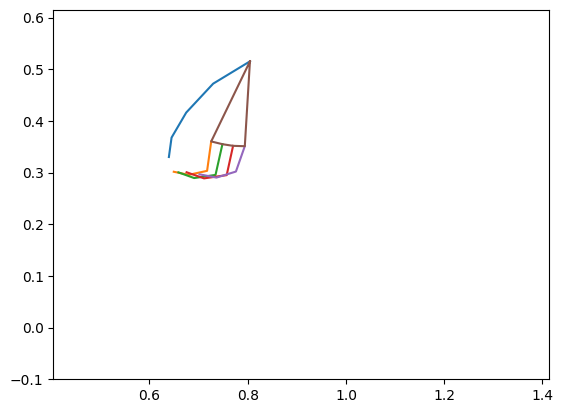

In [ ]:
#### VISUALIZE DATA

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

lips_m = np.nan_to_num(lips_3d[:,:,:,0:DIMS], copy=False)
lips_m[:,:,:,0] = lips_3d[:,:,:,0].max() - lips_3d[:,:,:,0]
left_m = np.nan_to_num(lefth_3d[:,:,:,0:DIMS], copy=False)
left_m[:,:,:,0] = lefth_3d[:,:,:,0].max() - lefth_3d[:,:,:,0]
pose_m = np.nan_to_num(pose_3d[:,:,:,0:DIMS], copy=False)
pose_m[:,:,:,0] = pose_3d[:,:,:,0].max() - pose_3d[:,:,:,0]
right_m = np.nan_to_num(righth_3d[:,:,:,0:DIMS], copy=False)
right_m[:,:,:,0] = righth_3d[:,:,:,0].max() - righth_3d[:,:,:,0]

#vid = left_m[20000,:,:,:]
vid = lefth_3d[20000,:,:,:]


# Functions to define landmark lines from the data
def get_hand_points(hand):
    x = [[hand[0,0],  hand[1,0],  hand[2,0],  hand[3,0], hand[4,0]], # Thumb
         [hand[5,0],  hand[6,0],  hand[7,0],  hand[8,0]], # Index
         [hand[9,0],  hand[10,0], hand[11,0], hand[12,0]], 
         [hand[13,0], hand[14,0], hand[15,0], hand[16,0]], 
         [hand[17,0], hand[18,0], hand[19,0], hand[20,0]], 
         [hand[0,0],  hand[5,0],  hand[9,0],  hand[13,0], hand[17,0], hand[0,0]]]

    y = [[hand[0,1],  hand[1,1],  hand[2,1],  hand[3,1], hand[4,1]], # Thumb
         [hand[5,1],  hand[6,1],  hand[7,1],  hand[8,1]], # Index
         [hand[9,1],  hand[10,1], hand[11,1], hand[12,1]], 
         [hand[13,1], hand[14,1], hand[15,1], hand[16,1]], 
         [hand[17,1], hand[18,1], hand[19,1], hand[20,1]], 
         [hand[0,1],  hand[5,1],  hand[9,1],  hand[13,1], hand[17,1], hand[0,1]]]

    return x, y

def animation_frame(v):
    lx, ly = get_hand_points(v)
    ax.clear()
    for i in range(len(lx)):
        ax.plot(lx[i], ly[i])
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

xmin = vid[:,:,0].min() - 0.1
xmax = vid[:,:,0].max() + 0.1
ymin = vid[:,:,1].min() - 0.1
ymax = vid[:,:,1].max() + 0.1

fig, ax = plt.subplots()
(l,) = ax.plot([], [])
animation = FuncAnimation(fig, func=animation_frame, frames=vid, interval=300)

HTML(animation.to_html5_video())

In [44]:
# SAVER
#class ASLData(Dataset):
    def __init__(self, datax, datay):
        self.datax = datax
        self.datay = datay

    def __getitem__(self, index):
        return self.datax[index, :], self.datay[index]

    def __len__(self):
        return len(self.datay)

# https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab
class ASLModel(nn.Module):
    def __init__(self, p):
        super(ASLModel, self).__init__()
        self.flatten = nn.Flatten()
        self.batchnorm0 = nn.BatchNorm1d(FRAMES_OUT * PTS_IN_FRAME * DIMS)
        self.dropout0 = nn.Dropout(p)
        
        self.layer1 = nn.Linear(FRAMES_OUT * PTS_IN_FRAME * DIMS, 512)
        self.batchnorm1 = nn.BatchNorm1d(512)

        self.layer2 = nn.Linear(512, 512)
        self.batchnorm2 = nn.BatchNorm1d(512)

        self.layerFC = nn.Linear(512, 250)
 
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p)
        
    def forward(self, x):
        x = self.flatten(x)
        # x = self.batchnorm0(x)
    
        x = self.layer1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.layer2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.layerFC(x)

        return x




#ROCKET

In [107]:
!pip install sktime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 69.1 MB/s eta 0:00:00


In [108]:

from sklearn.linear_model import RidgeClassifierCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier

from sktime.transformations.panel.rocket import (
    MiniRocket,
    MiniRocketMultivariate,
    MiniRocketMultivariateVariable,
)


In [109]:
# FILTER TO REDUCE DATASET SIZE 
datax = datax[datay < 20]
datay = datay[datay < 20]
print("DATAX", datax.shape, datay.shape)


DATAX (7528, 12, 40, 3) (7528,)


In [110]:
# FIXED SIZE MODEL
#datax = np.nan_to_num(datax, copy=False)
datax = datax[:,:,-1]
datax = datax.swapaxes(1,2) # swap frame with data
trainx, testx, trainy, testy = train_test_split(datax, datay, test_size=0.15, random_state=42)

minirocket_multi = MiniRocketMultivariate()
minirocket_multi.fit(trainx)
X_train_transform = minirocket_multi.transform(trainx)

scaler = StandardScaler(with_mean=False)
X_train_scaled_transform = scaler.fit_transform(X_train_transform)

#classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
classifier = SGDClassifier(loss='log')
classifier.fit(X_train_scaled_transform, trainy)

X_test_transform = minirocket_multi.transform(testx)
X_test_scaled_transform = scaler.transform(X_test_transform)
classifier.score(X_test_scaled_transform, testy)


0.09646017699115045